In [9]:
! pip install -q 'gwosc==0.5.4'
! pip install pycbc

### Challenge 1, Assignment set 1
Identify a loud binary black hole signal in white, Gaussian noise.
● Use the data file "challenge1.gwf". The channel name is "H1:CHALLENGE1". italicized text ● The data are white, Gaussian noise containing a simulated BBH signal.

Load the data into memory. What are the sampling rate and duration of the data?
Plot the data in the time-domain.
Plot a spectrogram (or q-transform) of the data, and try to identify the signal.
What is the time of the merger?
The code for this section was created using the recource Gravitational Wave Open Data Workshop by Ligo Virgo

Step 1: Importing the data file and installing the appropriate packages

In [10]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge1.gwf', 'H1:CHALLENGE1')

In [11]:
# -- for gwpy
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt

Extracting the Sampling rate in Hz and the duartion of the data

In [12]:
# Load the data
data = TimeSeries.read('challenge1.gwf', channel='H1:CHALLENGE1')

# Determine the sampling rate and duration
sampling_rate = data.sample_rate.value
duration = data.duration.value

print("Sampling Rate:", sampling_rate, "Hz")
print("Duration:", duration, "seconds")

Sampling Rate: 4096.0 Hz
Duration: 128.0 seconds


Plotting the data in the time domain Details: The x axis time represents the time during which the gravitational wave was observed in seconds The y axis strain represents the change in length caused by the passing gravitational wave and is dimensionless.

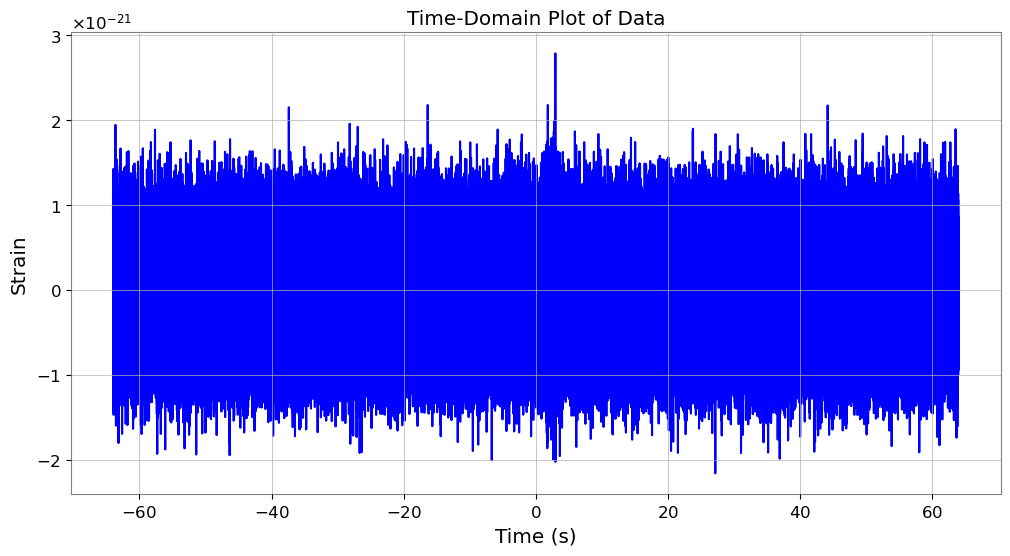

In [13]:
# 2. Plot the data in the time-domain
plt.figure(figsize=(12, 6))
plt.plot(data.times, data, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Time-Domain Plot of Data')
plt.grid(True)
plt.show()

Plot a spectrogram (or q-transform) of the data, and try to identify the signal.

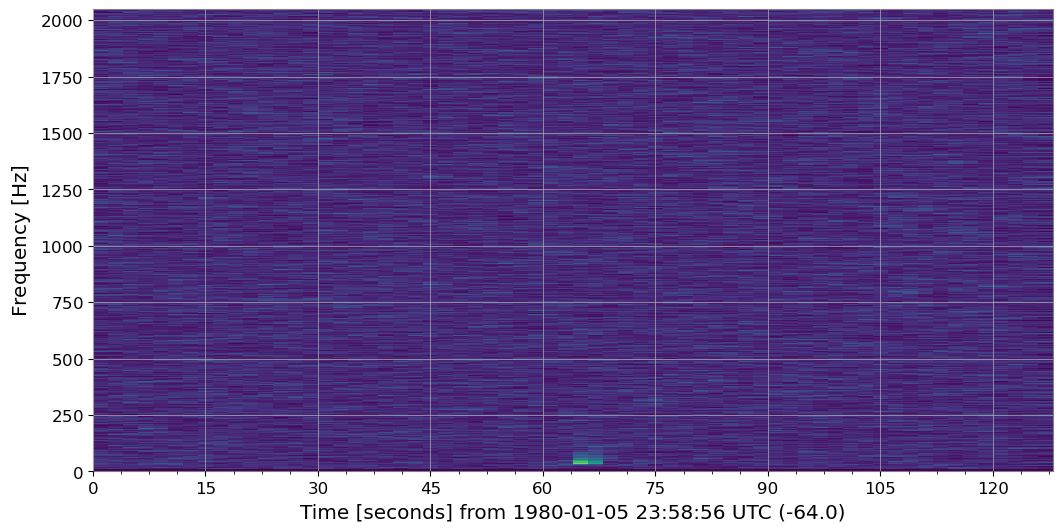

In [14]:
specgram = data.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()

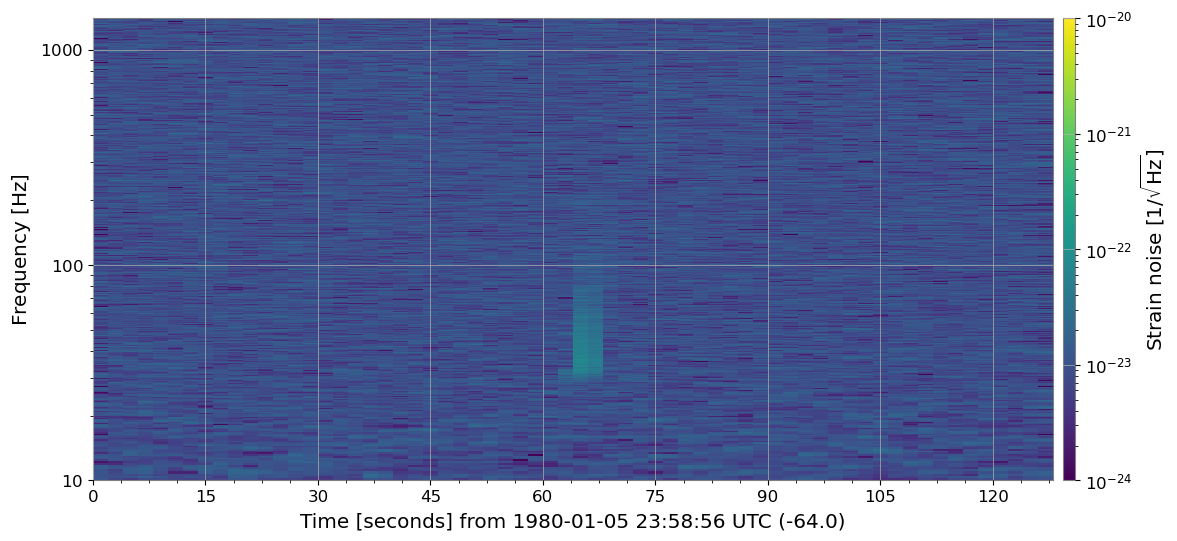

In [15]:
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.colorbar(
    clim=(1e-24, 1e-20),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot  # refresh

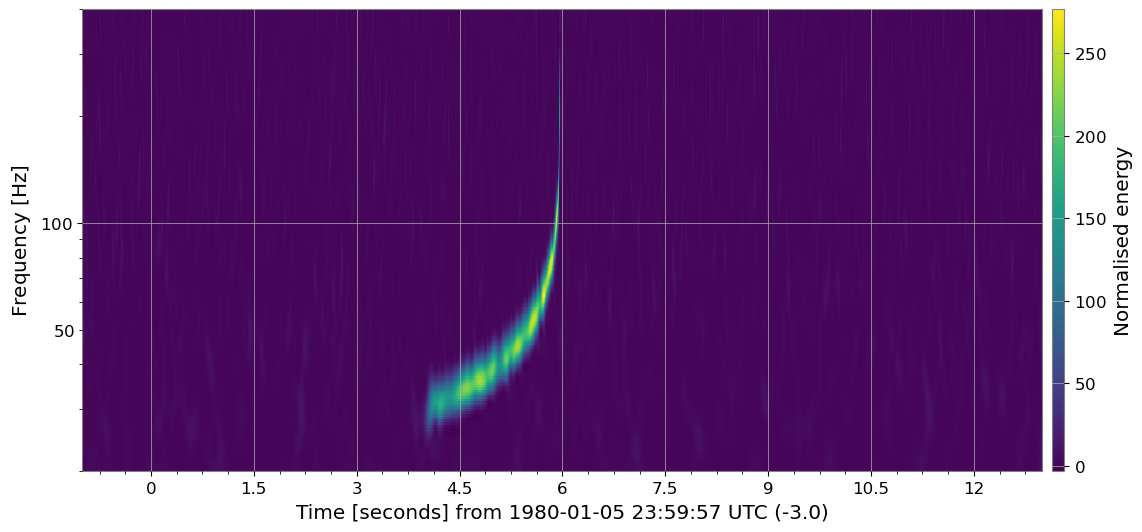

In [16]:
hq = data.q_transform(frange=(20, 400), qrange=(10, 15), outseg=(-4,10))
plot = hq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

What is the time of the merger?

In [17]:
# Find the time of merger
time_of_merger = data.times[data.argmax()]

print("Time of Merger:", time_of_merger)

Time of Merger: 2.966552734375 s


### Challenge 2
Assignment set 1 Signal in colored, Gaussian noise.

● Use the data file "challenge2.gwf", with channel name "H1:CHALLENGE2"

● The data contain a BBH signal with m1=m2=30 solar masses, spin = 0.

1. What is the approximative time of the merger? (Hint: a plot of the q-transform could help)

In [18]:
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
data = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

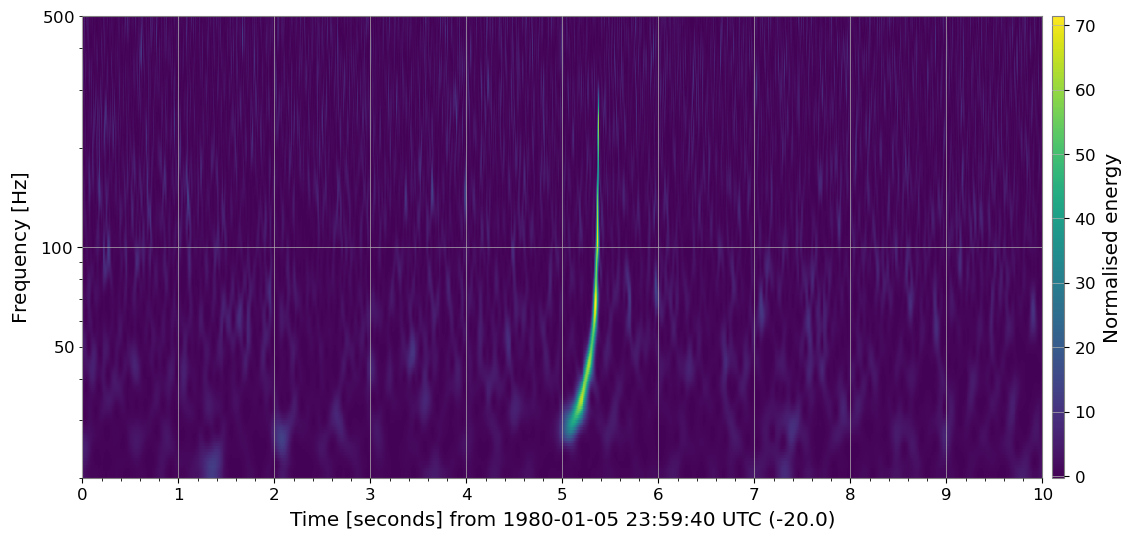

In [19]:
hq = data.q_transform(frange=(20, 500), qrange=(10, 15), outseg=(-20,-10))
plot = hq.plot()
ax = plot.gca()
ax.set_yscale('log')
t_est=-14.62
ax.colorbar(label="Normalised energy")

In [20]:
import numpy as np

# Find the time of merger
peak_index = np.argmax(data)
time_of_merger = data.times[peak_index]

print("Time of Merger:", time_of_merger)

Time of Merger: -26.953125 s


2. Generate a time-domain template waveform using approximate "SEOBNRv4_opt". with the same parameters as above. Plot this waveform.

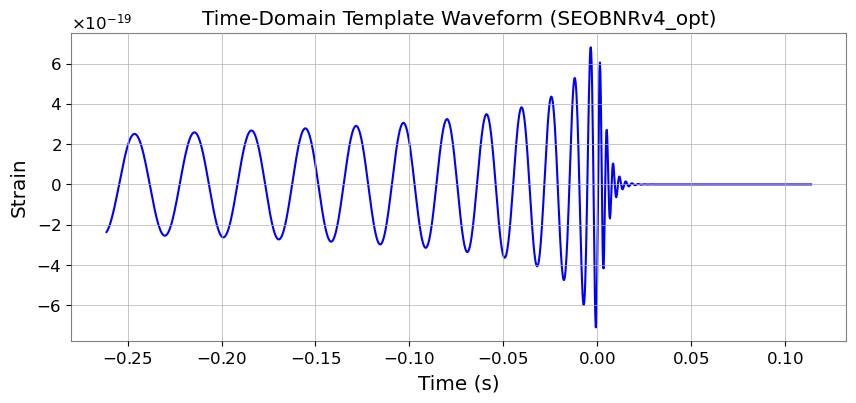

In [21]:
from pycbc.waveform import get_td_waveform

m=30 # Solar masses
spin1z = 0  # Dimensionless spin (z-component)

# Generate time-domain template waveform
hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         spin=spin1z ,
                         delta_t=1.0/4096,
                         f_lower=30)

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(hp.sample_times, hp, 'b-')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Time-Domain Template Waveform (SEOBNRv4_opt)')
plt.grid(True)
plt.show()

3. Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging from 20 Hz up to the Nyquist frequency.

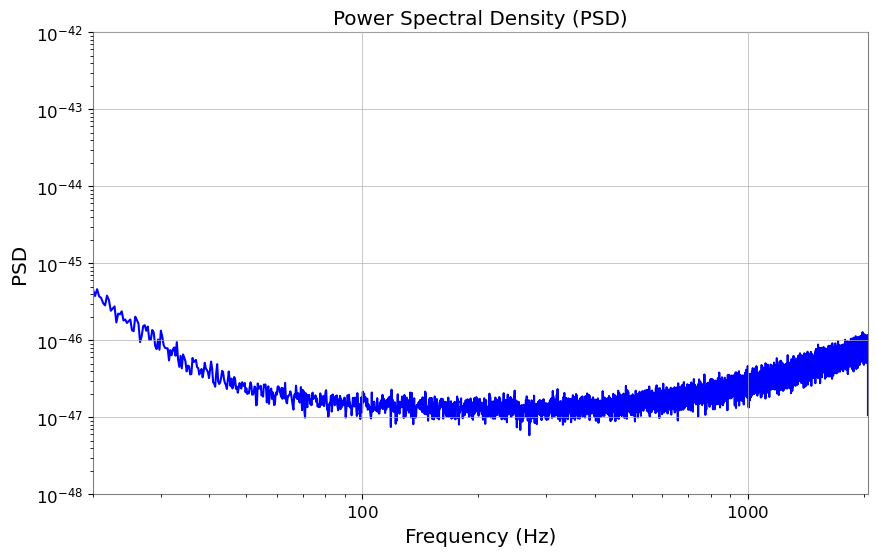

In [22]:
import numpy as np
nyqf=4096/2

# Calculate the PSD
psd = data.psd(fftlength=4)

plt.figure(figsize=(10, 6))
plt.loglog(psd.frequencies.value, psd.value, color='blue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('Power Spectral Density (PSD)')
plt.xlim(20, nyqf)
plt.ylim(1e-48,1e-42)
plt.show()

4. Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.
What is the matched filter SNR of the signal?

In [23]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
conditioned = pycbc_strain.crop(2, 2)
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)


In [24]:
from pycbc.waveform import get_td_waveform
import pylab

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

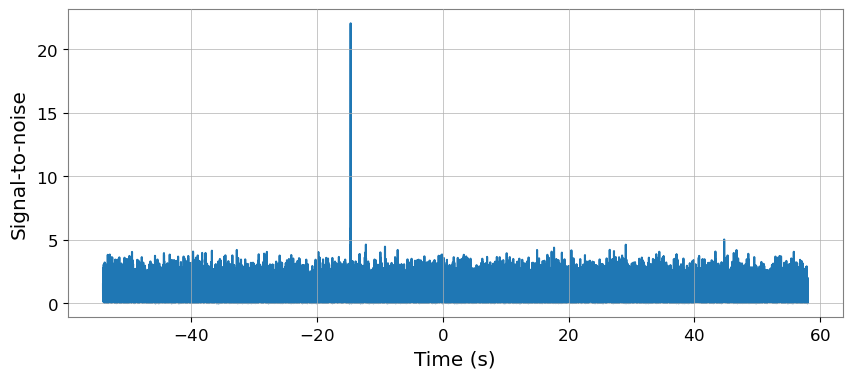

We found a signal at -14.6328125s with SNR 22.055412799223888


In [25]:
from pycbc.filter import matched_filter

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

### DETECTOR NOISE: Problem 2, set 2. 

1. Load the data of the LIGO Hanford detector from [2]. Plot the noise power spectral density (PSD) of that data. Test whether there is any gravitational wave signal present in the data or not? For this test, you can assume the GW signals can produce only from equal mass binary systems with a range between 5 to 10. We assume a threshold on matched filter SNR of 8 to claim detection of GW.


In [26]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



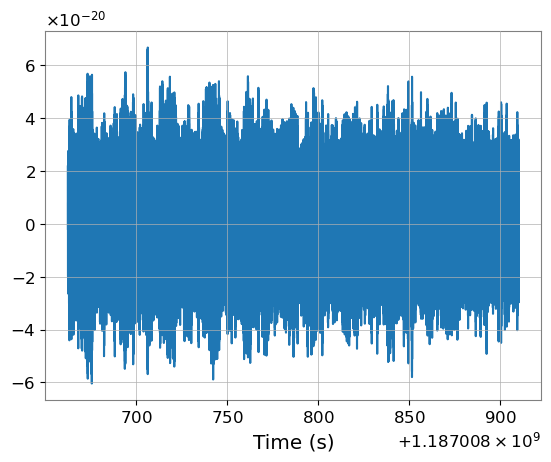

In [27]:
#copied from set2 hints
%matplotlib inline
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame

merger = Merger("GW170817")
strain, stilde = {}, {}

for ifo in ['H1', 'L1']:
   
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                    start_time=merger.time - 224,
                    end_time=merger.time + 32,
                    check_integrity=False)

    strain[ifo] = highpass(ts, 15)

    strain[ifo] = strain[ifo].crop(4, 4)

    stilde[ifo] = strain[ifo].to_frequencyseries()

pylab.plot(strain['H1'].sample_times, strain['H1'])
pylab.xlabel('Time (s)')
pylab.show()

In [33]:
from gwpy.timeseries import TimeSeries

# Assuming 'strain' is your data and 'time' is your time array
d=np.load('noise_ts_4096Hz.npy')
strain = d[:, 1]
dt = time[1] - time[0]
sample_rate = 1.0 / dt  # Sample rate is the inverse of the time step

# Create TimeSeries object
data = TimeSeries(strain, sample_rate=sample_rate)

IndexError: invalid index to scalar variable.

In [34]:
# Calculate the sampling interval
dt = np.mean(np.diff(time))

# Calculate the sampling rate
sampling_rate3 = 1 / dt

print("Sampling rate:", sampling_rate, "Hz")

ValueError: diff requires input that is at least one dimensional

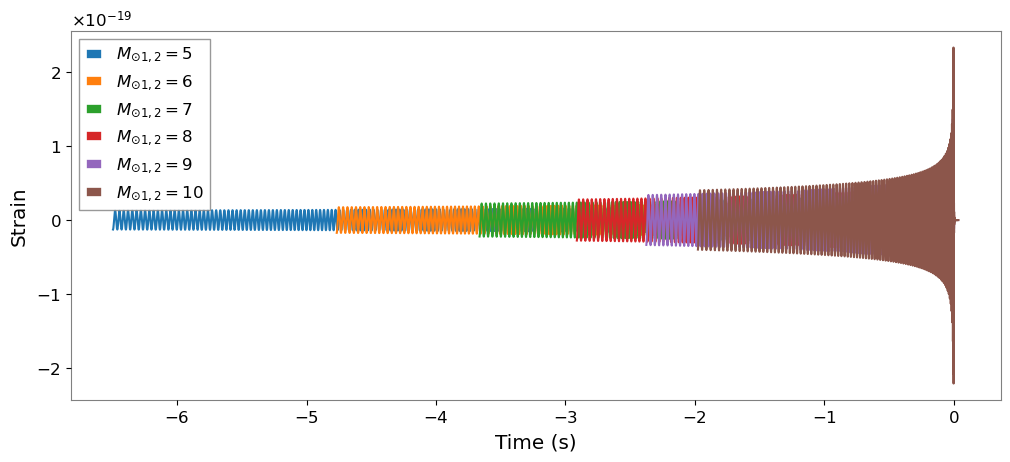

In [35]:
# Component mass of each binary component. We'll simplify here and assume that each
# component of the binary has the same mass. Again, units are in solar masses.
pylab.figure(figsize=pylab.figaspect(0.4))
for m in [5, 6, 7, 8, 9, 10]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)

    pylab.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.show()

In [36]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
conditioned = pycbc_strain.crop(2, 2)
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [37]:
for m in [5, 6, 7, 8, 9, 10]:
  hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

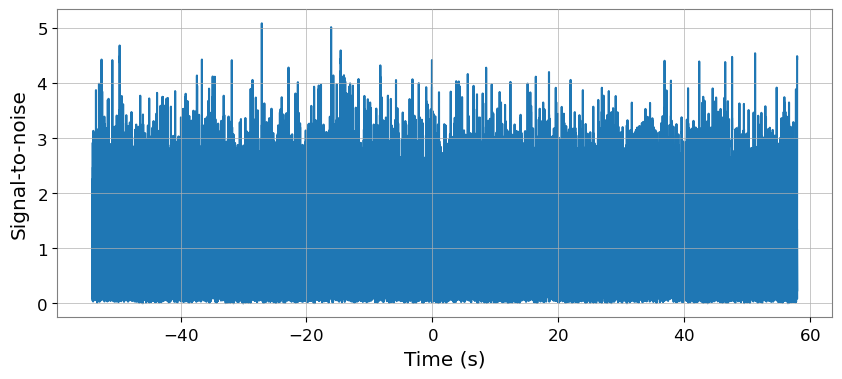

We found a signal at -27.099365234375s with SNR 5.089828475895446


In [38]:
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

2. Whiten the above data using its noise PSD. You can use PyCBC based function of the
Welch method to estimate the PSD. Construct a histogram of the whitened data and
show that the whiten data follows a Gaussian distribution with zero mean.

In [39]:
# Assuming you have defined `conditioned` properly before attempting to whiten it
# Also assuming `psd` is properly defined
# Define `conditioned` here or somewhere earlier in your code

# Whitening the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white = white_data.crop(4, 4)

In [40]:
# Whitening the data.

white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white = white_data.crop(4,4)

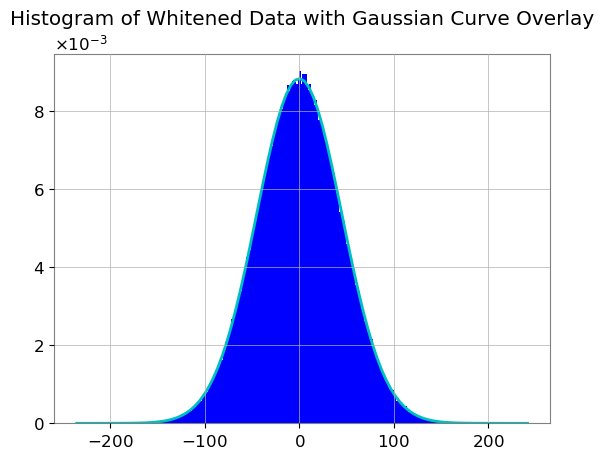

Mean=0.00, Standard Deviation=45.17)


In [41]:
# Plotting a histogram of the whitened data with a Gaussian fit overlay.
from scipy.stats import norm

mean = np.mean(white)
std_dev = np.std(white)

hist=plt.hist(white,bins='auto', density=True, color = 'b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, color='c', linewidth=2);
plt.title("Histogram of Whitened Data with Gaussian Curve Overlay")
plt.show()
print(f"Mean={mean:.2f}, Standard Deviation={std_dev:.2f})")

3. In gravitational wave data analysis, we consider that the noise is stationary Gaussian.
But in reality, the stationary assumption does not hold. Can you think of a test to
show that the stationarity does not hold?
[To devise this test, you can consider the above data (?). Take a arbitrary gravitational
waveform h(f ) and calculate the optimal SNR ρopt, FORMULA GIVEN, where Sn(f ) is noise power spectral density of the data. For the test, you can consider
different chunk of data]

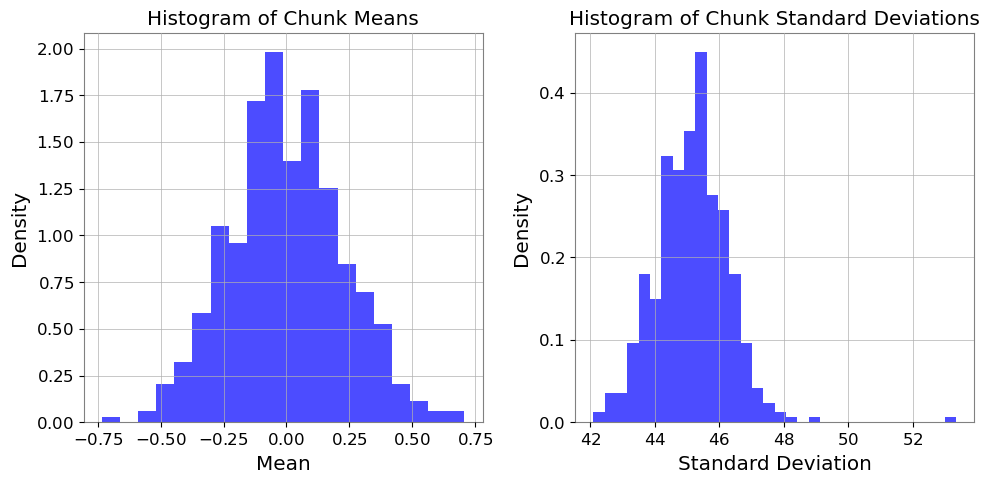

In [53]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

# Divide data into chunks (adjust chunk size as needed)
chunk_size = 1000
num_chunks = len(white) // chunk_size
chunks = np.array_split(white, num_chunks)

# Calculate mean and standard deviation for each chunk
chunk_means = [np.mean(chunk) for chunk in chunks]
chunk_std_devs = [np.std(chunk) for chunk in chunks]

# Plot histograms of mean and standard deviation
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(chunk_means, bins='auto', density=True, color='b', alpha=0.7)
plt.title('Histogram of Chunk Means')
plt.xlabel('Mean')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(chunk_std_devs, bins='auto', density=True, color='b', alpha=0.7)
plt.title('Histogram of Chunk Standard Deviations')
plt.xlabel('Standard Deviation')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

There are noticeable variations HENCE suggests non-stationarity in the data. 

I 

Resource:  GW_BigData_tutorial-2 found in the module section of the PRA3024 Canvas page.
https://canvas.maastrichtuniversity.nl/courses/17323/files/3534550/download?download_frd=1